In [1]:
from torch import nn
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def number_to_feature_vector(n, n_min=0, n_max=1000):
    """
    Convert a number to a 42-feature vector:
    - 10 least significant digits from binary, ternary, quinary, septenary representations
    - Normalized number
    - Normalized logarithm of the number
    
    Parameters:
    n (int/float): Input number (positive)
    n_min (float): Minimum value for normalization (default: 0)
    n_max (float): Maximum value for normalization (default: 1000)
    
    Returns:
    np.array: 42-dimensional feature vector
    """
    feature_vector = []
    
    def to_base_digits(num, base, k=10):
        if num == 0:
            return [0] * k
        digits = []
        while num > 0 and len(digits) < k:
            digits.append(num % base)
            num //= base
        while len(digits) < k:
            digits.append(0)
        return digits[::-1][:k]
    
    bases = [2, 3, 5, 7]  
    for base in bases:
        digits = to_base_digits(int(n), base, 10)
        feature_vector.extend(digits)
    
    # Normalize the number (min-max scaling)
    n_norm = (n - n_min) / (n_max - n_min) if n_max != n_min else 0.0
    feature_vector.append(n_norm)
    
    log_n = np.log(n) if n > 0 else 0.0
    log_min = np.log(n_min) if n_min > 0 else -10
    log_max = np.log(n_max) if n_max > 0 else 10  
    log_norm = (log_n - log_min) / (log_max - log_min) if log_max != log_min else 0.0
    feature_vector.append(log_norm)
    
    return np.array(feature_vector)




In [3]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout=0.01):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        batch_size = x.size(0)
        
        h_0 = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        c_0 = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        
        # Forward pass through LSTM
        out, _ = self.lstm(x, (h_0, c_0))  # Pass initial hidden and cell states
        out = self.linear(out[:, -1, :])
        out = self.relu(out)
        return out

In [4]:
class GoldbachDataset(Dataset):
    def __init__(self, file_name):
        self.df = pd.read_csv(file_name)
        self.numbers = self.df["Even_number"]
        self.combinations = self.df["combination"]
        self.features = np.array([number_to_feature_vector(n) for n in self.numbers])

    def __len__(self):
        return len(self.numbers)
    
    def __getitem__(self, index):
        feature = self.features[index]  # Shape: (42,)
        combination = self.combinations[index]  # Scalar or single value
        return {"number": feature, "combination": combination}

In [5]:
data = GoldbachDataset("data.csv")


In [6]:
function = LSTMModel(42,356,5)
data_loader = DataLoader(data, batch_size=32,shuffle=True)


In [7]:
loss_fn = torch.nn.MSELoss()

optimizer = torch.optim.SGD(function.parameters(), lr=0.01)

In [8]:
def train_epoch():
    running_loss = 0

    for data in data_loader:
        inputs = data["number"].to(dtype =torch.float32) 
        labels = data["combination"].to(dtype = torch.float32)
        

        inputs = inputs.unsqueeze(1)
        optimizer.zero_grad()
        outputs = function(inputs).squeeze()  
        loss = loss_fn(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(function.parameters(), max_norm=1.0)
        optimizer.step()
        running_loss += loss.item()

    return running_loss / len(data_loader)

In [ ]:
epochs = 100

for epoch in range(epochs):

    function.train(True)
    avg_loss = train_epoch()
    if epoch % 10 == 0:
        print(f"Epoch:{epoch+1} loss:{avg_loss}")

In [24]:
function.eval()
vec = number_to_feature_vector(100)
vec = torch.tensor(vec, dtype=torch.float32)
vec = vec.unsqueeze(0)
vec = vec.unsqueeze(1)
with torch.no_grad():
    out = function(vec) 
    print(out)

tensor([[0.]])


In [12]:
torch.save(function.state_dict(), "Function_lstm.pth")
df = pd.read_csv("data.csv")
df.head()
print(len(df))

336645


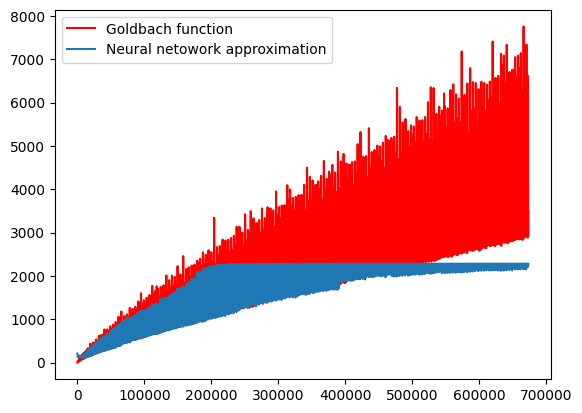

In [15]:
even_number = df["Even_number"][::100]

combination = df["combination"][::100]
tensors =[]
function.eval()
out_lis = []

for i in even_number:
    tensors.append(torch.tensor(number_to_feature_vector(i),dtype=torch.float32))
with torch.no_grad():
    for j in tensors:
        j = j.unsqueeze(0)
        out  = function(j.unsqueeze(1))
        out_lis.append(out.item())
plt.plot(even_number, combination, color="red",label ="Goldbach function")
plt.plot(even_number,out_lis,label = "Neural netowork approximation")
plt.legend()
plt.show()